In [48]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import kagglehub

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


In [40]:
df = pd.read_csv("HistoricalQuotes.csv")

df.columns = df.columns.str.strip()

df.rename(columns={
    'Close/Last': 'Close',
    'Volume': 'Volume',
    'Open': 'Open',
    'High': 'High',
    'Low': 'Low'
}, inplace=True)

for col in ['Close', 'Open', 'High', 'Low']:
    df[col] = df[col].replace({'\$': ''}, regex=True).astype(float)

df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.head())

        Date    Close     Volume     Open     High      Low
0 2010-03-01  29.8557  137312041  29.3928  29.9286  29.3500
1 2010-03-02  29.8357  141486282  29.9900  30.1186  29.6771
2 2010-03-03  29.9043   92846488  29.8486  29.9814  29.7057
3 2010-03-04  30.1014   89591907  29.8971  30.1314  29.8043
4 2010-03-05  31.2786  224647427  30.7057  31.3857  30.6614


In [49]:
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_features = df[feature_cols].values
target_col_index = feature_cols.index('Close')

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_features)

In [51]:
def create_sequences(data, seq_length, target_idx):
    X_seqs, y_seqs = [], []
    for i in range(len(data) - seq_length):
        X_seq = data[i : i + seq_length]
        y_seq = data[i + seq_length, target_idx]
        X_seqs.append(X_seq)
        y_seqs.append(y_seq)
    return np.array(X_seqs), np.array(y_seqs)

seq_length = 100
X, y = create_sequences(scaled_features, seq_length, target_col_index)

In [52]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [44]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Train set shape: (1990, 30, 5), Test set shape: (498, 30, 5)


In [53]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [46]:
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 0.0095 - val_loss: 0.0056
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 8.0984e-04 - val_loss: 0.0021
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 6.8910e-04 - val_loss: 0.0017
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 6.1645e-04 - val_loss: 0.0020
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 7.1704e-04 - val_loss: 7.9734e-04
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 5.8537e-04 - val_loss: 0.0016
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 5.1165e-04 - val_loss: 0.0015
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.0729e-04 - val_loss: 0.0013
Epoch 9/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 4.2562e-04 - val_loss: 0.0032
Epoch 10/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.5017e-04 - val_loss: 0.0015
Epoch 11/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 5.1186e-04 - val_loss: 0.0018
Epoch 12/15
63/63 

In [54]:
batch_size = 32
train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=batch_size, shuffle=False)


In [55]:
class LSTMCNNModel(nn.Module):
    def __init__(self, num_features, lstm_hidden_size=64, cnn_channels=32, num_layers=1):
        super(LSTMCNNModel, self).__init__()
        self.lstm = nn.LSTM(input_size=num_features,
                            hidden_size=lstm_hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=0.0,
                            bidirectional=False)
        self.conv1d = nn.Conv1d(in_channels=lstm_hidden_size,
                                out_channels=cnn_channels,
                                kernel_size=3,
                                padding=1)
        self.fc = nn.Linear(cnn_channels, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out.transpose(1, 2)
        conv_out = self.conv1d(lstm_out)
        pooled = torch.mean(conv_out, dim=2)
        out = self.fc(pooled)
        return out.squeeze()


In [57]:
num_features = X_train.shape[2]
model = LSTMCNNModel(num_features=num_features).to(device)

In [58]:
num_epochs = 101
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_list = []
train_mae_list = []

In [59]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_preds, epoch_targets = [], []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * X_batch.size(0)
        epoch_preds.append(outputs.detach().cpu().numpy())
        epoch_targets.append(y_batch.detach().cpu().numpy())

    epoch_loss /= len(train_loader.dataset)
    train_loss_list.append(epoch_loss)

    all_preds = np.concatenate(epoch_preds)
    all_targets = np.concatenate(epoch_targets)
    epoch_mae = mean_absolute_error(all_targets, all_preds)
    train_mae_list.append(epoch_mae)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.6f}, MAE: {epoch_mae:.6f}")

print("Training complete!")


Epoch [10/101] - Loss: 0.000721, MAE: 0.020870
Epoch [20/101] - Loss: 0.000685, MAE: 0.020347
Epoch [30/101] - Loss: 0.000723, MAE: 0.020800
Epoch [40/101] - Loss: 0.000724, MAE: 0.021044
Epoch [50/101] - Loss: 0.000693, MAE: 0.020569
Epoch [60/101] - Loss: 0.000692, MAE: 0.020543
Epoch [70/101] - Loss: 0.000670, MAE: 0.020251
Epoch [80/101] - Loss: 0.000687, MAE: 0.020475
Epoch [90/101] - Loss: 0.000678, MAE: 0.020579
Epoch [100/101] - Loss: 0.000614, MAE: 0.019264
Training complete!


In [60]:
model.eval()
test_loss = 0.0
all_preds, all_targets = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        test_loss += loss.item() * X_batch.size(0)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.cpu().numpy())

test_loss /= len(test_loader.dataset)
rmse = np.sqrt(test_loss)
print(f"Test RMSE: {rmse:.6f}")


Test RMSE: 0.074551


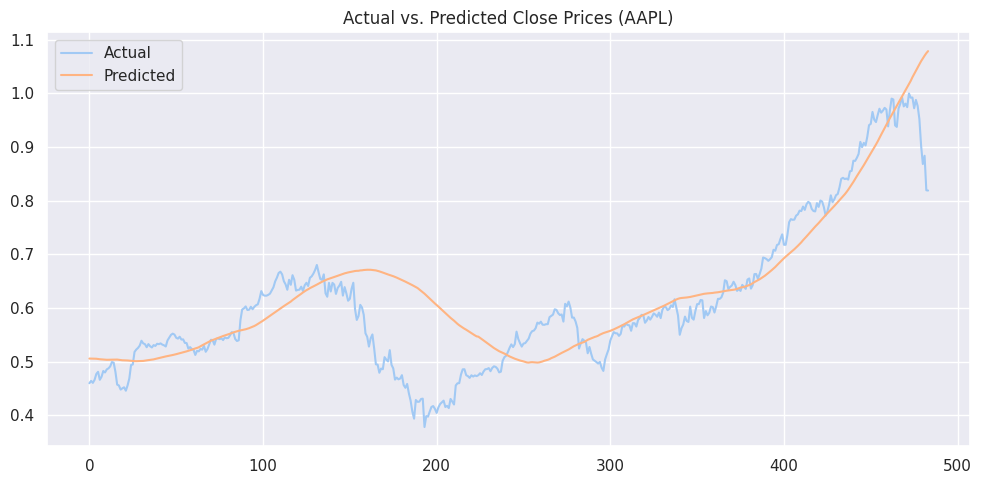

In [61]:
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

plt.figure(figsize=(10, 5))
plt.plot(all_targets, label='Actual')
plt.plot(all_preds, label='Predicted')
plt.title('Actual vs. Predicted Close Prices (AAPL)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()